# Initial Data Exploration

This notebook explores our datasets and sets a precedent on how to use our pipelines

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

%cd ..

/home/williamglazer/Documents/school/projet/IFT6759_B_H23


In [2]:
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler
from darts.models import LinearRegressionModel
from darts.metrics import mape
from darts.utils.statistics import plot_residuals_analysis, extract_trend_and_seasonality

In [3]:
DATA_PATH = 'data/raw/exchange_rate/exchange_rate.txt'

## Loading the data

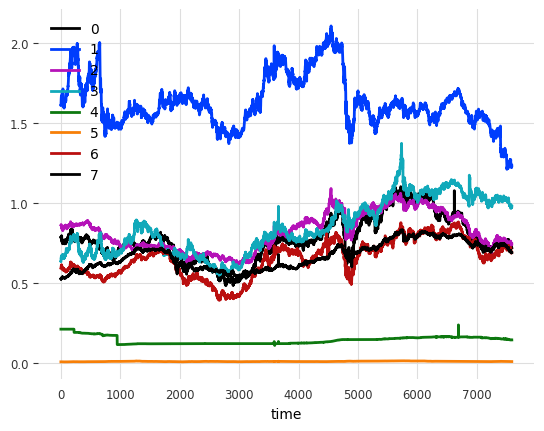

In [4]:
series = TimeSeries.from_csv(DATA_PATH, header=None)
series.plot()

## Preprocessing

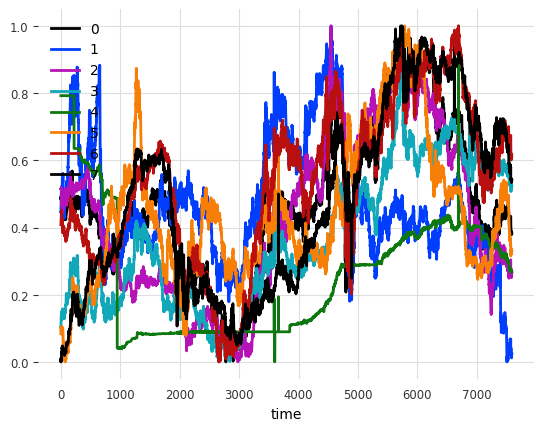

In [11]:
transforms = [
    Scaler()
]
pipeline = Pipeline(transforms)

transformed = pipeline.fit_transform(series)+1e-9  # avoids 0 error
transformed.plot()

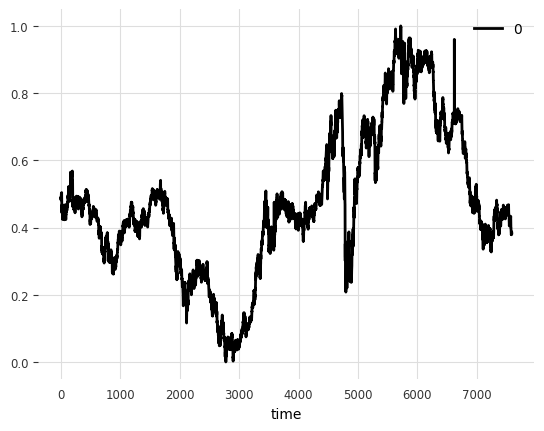

In [12]:
first_component = transformed.univariate_component(0)
first_component.plot()

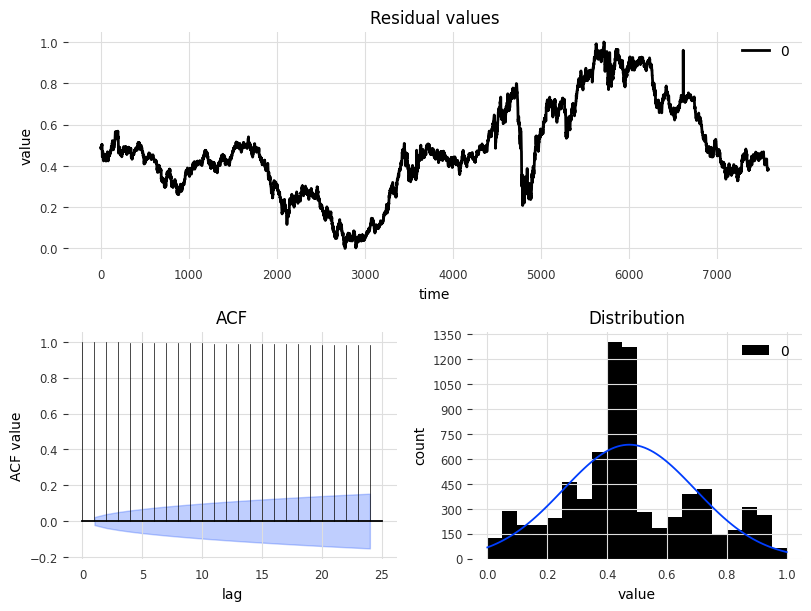

In [13]:
plot_residuals_analysis(first_component)

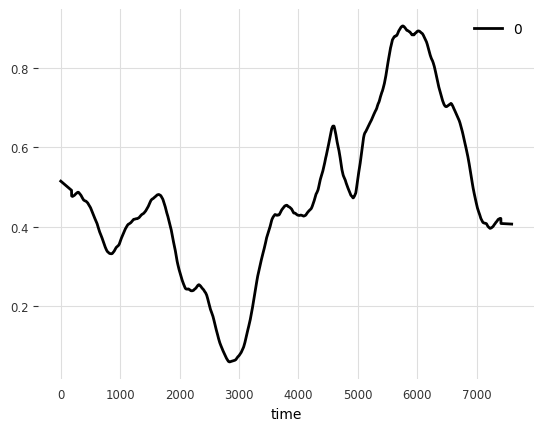

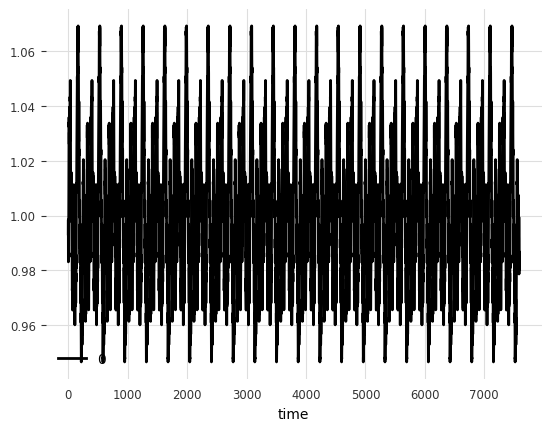

In [14]:
# we know our data is daily, and monthly/weekly data does not smooth out our timeseries, yet yearly does
trend, seasonality = extract_trend_and_seasonality(first_component, freq=365)

trend.plot('trend')
seasonality.plot('seasonality')

## Model Training

Here we use backtesting (using our models over a certain horizon with a stride of 1) to fit our lag hyper-parameter

We then evaluate our best valiadtion performance over a horizon of 12 on our test set

In [53]:
data = first_component

In [31]:
# 80, 20, 20 split
train, test = data.split_before(0.80)
train, valid = train.split_before(0.75)

# gridsearch
error = dict()
for lags in range(1, 16, 1):
    # fit
    model = LinearRegressionModel(lags=lags)
    model.fit(train)

    # backtest evaluation
    error[lags] = model.backtest(
        valid,
        stride=1,
        metric=mape,
        forecast_horizon=12,
        retrain=False
    )

100%|██████████| 15/15 [03:42<00:00, 14.85s/it]


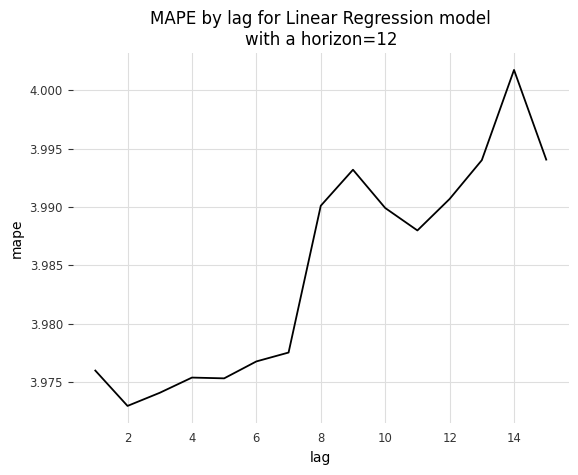

In [37]:
# error plot
plt.plot(error.keys(), error.values())
plt.title('MAPE by lag for Linear Regression model\nwith a horizon=12')
plt.xlabel('lag')
plt.ylabel('mape')
plt.show()

In [54]:
# true error
best_lag = min(error, key=error.get)

model = LinearRegressionModel(lags=best_lag)
model.fit(train)
final_mape = model.backtest(
    test,
    stride=1,
    metric=mape,
    forecast_horizon=12,
    retrain=False
)

print(f'Best Hparam model gets\nMAPE: {final_mape}')

Best Hparam model gets
MAPE: 2.556855594395755


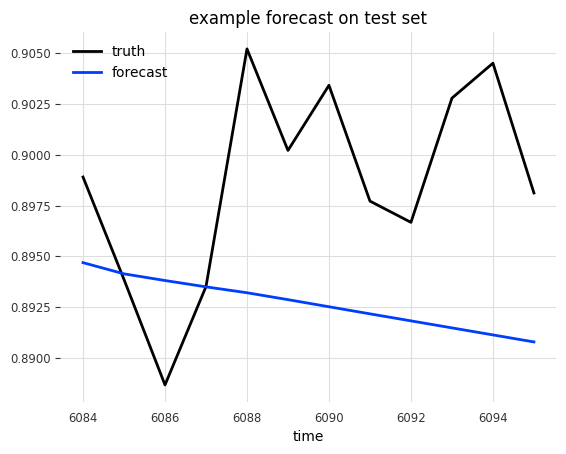

In [73]:
# Example forecast vizualisation
forecast = model.predict(n=12, series=test[0:15])
test[15:15+12].plot(label='truth')
forecast.plot(label='forecast')
plt.title('example forecast on test set')
plt.show()